# Тестирование производительности
## Описание экспериментов
Данный блокнот сделан с целью выявления наилучших параметров по умолчанию для оптимизации динамической регрессии. Будут подбираться следующие параметры:
- `learning_steps`
- `ar_depth`
- `seas_depth`
- `fit_intercept`
- `tolerance`
- `max_iter`
- стартовый набор параметров
- `lr_finder`

Параметры будут выбираться поочерёдно. Сначала набор параметров будет зафиксирован следующий:
- `learning_steps = 'all'`
- `ar_depth = 5`
- `seas_depth = 2`
- `fit_intercept = True`
- `tolerance = 1e-3`
- `max_iter = 1000`
- стартовый набор параметров -- случайный
- `lr_finder = Wolfe`

В качестве данных я возьму 6 рядов разной сезонности и длины из датасета M4: H1, D1, W1, Q1, M1. Прогнозировать буду на `fh=5`. Последние 5 значений ряда будут отрезаться и использоваться как тестовая выборка.

В каждой новой части эксперимента я буду подбирать отдельным способом новый параметр. Предыдущие параметры будут фиксироваться (заново) и считаться выбранными. Для каждого параметра будут строиться графики времени сходимости градиентного спуска и качества на тестовой выборке в зависимости от значения параметра. Общее правило при выборе параметров -- мы хотим выбрать параметры с максимальным качеством при минимальном времени.

## Эксперименты

Импортируем нужные библиотеки:

In [80]:
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from dynamic_regression import DynamicRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [64]:
columns = \
    [f"H{i}" for i in range(1, 2)] + \
    [f"D{i}" for i in range(1, 2)] + \
    [f"W{i}" for i in range(1, 2)] + \
    [f"M{i}" for i in range(1, 2)] + \
    [f"Q{i}" for i in range(1, 2)] + \
    [f"Y{i}" for i in range(1, 2)]
dataset = pd.DataFrame(columns=columns)
cur_period = None
for column in tqdm(columns):
    if cur_period is None or not column.startswith(cur_period):
        cur_period = columns[0]
        if column.startswith("H"):
            cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Hourly-train.csv")
        elif column.startswith("D"):
            cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Daily-train.csv")
        elif column.startswith("W"):
            cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Weekly-train.csv")
        elif column.startswith("M"):
            cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Monthly-train.csv")
        elif column.startswith("Q"):
            cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Quarterly-train.csv")
        elif column.startswith("Y"):
            cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Yearly-train.csv")
    series = cur_dataset[cur_dataset["V1"] == column].squeeze().dropna().drop(index='V1').astype(np.float64)
    series.index = range(len(series))
    series = series.reindex(range(10000))
    dataset[column] = series
dataset

  0%|          | 0/6 [00:00<?, ?it/s]

,H1,D1,W1,M1,Q1,Y1
0,605.0,1017.1,1089.20,8000.0,7407.412314,5172.1
1,586.0,1019.3,1078.91,8350.0,7528.566074,5133.5
2,586.0,1017.0,1079.88,8570.0,7374.709225,5186.9
3,559.0,1019.2,1063.58,7700.0,7395.514848,5084.6
4,511.0,1018.7,1060.61,7080.0,7654.007989,5182.0
...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,NaN
9996,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,NaN,NaN
9998,NaN,NaN,NaN,NaN,NaN,NaN


### `learning_steps`

Я вижу два разумных значения для параметра `learning_steps` -- это значение `'all'` и значение, равное `fh`. Слева на графике `'all'`, справа `fh`.

In [65]:
fh = np.array([5])
choices = ['all', np.array([5])]
df_times = pd.DataFrame(columns=['time', 'periodicity', 'choice'])
df_errors = pd.DataFrame(columns=['error', 'periodicity', 'choice'])
experiments = 5
row_iter = 0
for series in tqdm(columns[:30]):
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    for learning_steps in choices:
        for exp in range(experiments):
            model = DynamicRegression(fh=[5], learning_steps=learning_steps)
            status, history = model.fit(train, trace=True)
            if status == 'iterations_exceeded':
                print(f"Series {series} did not converge with learning_steps {learning_steps}")
                print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            df_times.loc[row_iter] = (history['time'][-1], series[0], learning_steps)
            df_errors.loc[row_iter] = (mean_squared_error([test[fh - 1]], model.predict(train)), series[0], learning_steps)
            row_iter += 1

  0%|          | 0/6 [00:00<?, ?it/s]

Series H1 did not converge with learning_steps all
Tolerance is 0.003136446094248822
Series H1 did not converge with learning_steps all
Tolerance is 0.038799045531289184
Series H1 did not converge with learning_steps all
Tolerance is 0.05557847706767948
Series H1 did not converge with learning_steps all
Tolerance is 0.05365257641954983
Series H1 did not converge with learning_steps all
Tolerance is 0.005048447301846184
Series H1 did not converge with learning_steps [5]
Tolerance is 0.08733036873135251
Series H1 did not converge with learning_steps [5]
Tolerance is 0.20490514691957995
Series H1 did not converge with learning_steps [5]
Tolerance is 0.01886667549035519
Series M1 did not converge with learning_steps all
Tolerance is 0.024993419293140872
Series M1 did not converge with learning_steps all
Tolerance is 0.030316629041834138
Series M1 did not converge with learning_steps all
Tolerance is 0.043045273470859305
Series M1 did not converge with learning_steps all
Tolerance is 0.0086

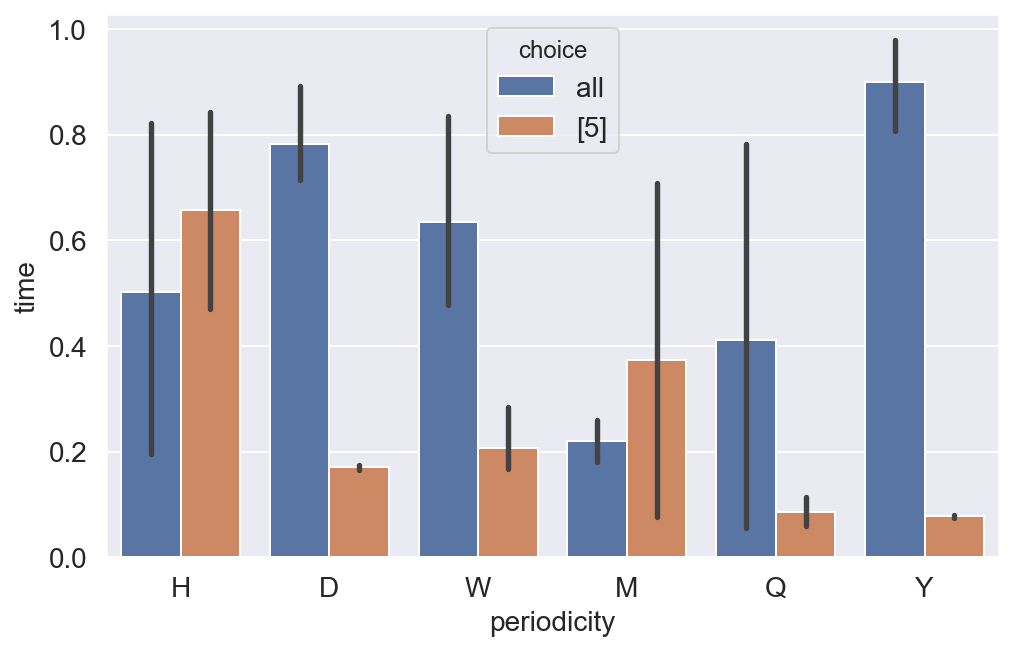

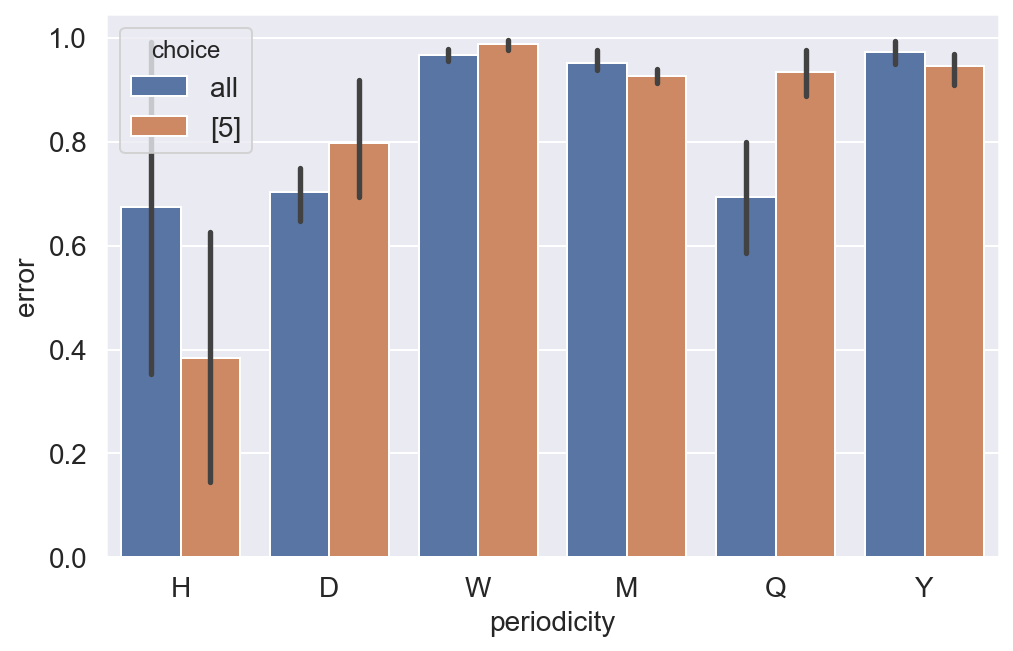

In [81]:
df_times['choice'] = df_times['choice'].astype(str)
df_errors['choice'] = df_errors['choice'].astype(str)
normalized_df_times = []
normalized_df_errors = []
for periodicity in df_times['periodicity'].unique():
    cur_time = df_times[df_times['periodicity'] == periodicity]['time']
    normalized_df_times.append(cur_time / cur_time.max())
    cur_error = df_errors[df_errors['periodicity'] == periodicity]['error']
    normalized_df_errors.append(cur_error / cur_error.max())
normalized_df_times = pd.concat(normalized_df_times)
normalized_df_times = pd.DataFrame({'time': normalized_df_times, 'periodicity': df_times['periodicity'], 'choice': df_times['choice']})
normalized_df_errors = pd.concat(normalized_df_errors)
normalized_df_errors = pd.DataFrame({'error': normalized_df_errors, 'periodicity': df_errors['periodicity'], 'choice': df_errors['choice']})
plot = sns.barplot(x='periodicity', y='time', hue='choice', data=normalized_df_times)
fig = plot.get_figure()
fig.savefig(fname='hyper-learning_steps-time.svg', format='svg')
plt.show()
plot = sns.barplot(x='periodicity', y='error', hue='choice', data=normalized_df_errors)
fig = plot.get_figure()
fig.savefig(fname='hyper-learning_steps-mse.svg', format='svg')
plt.show()

Мы видим, что по MSE у двух методов примерно одинаковый процент побед, но при этом всё-таки быстрее мы фитимся именно при методе `fh`, так что лучше выберем его.

### `ar_depth`

Параметр `ar_depth` будет подбираться среди значений [1, 5, 10, 15, 20, 25, 30].

In [83]:
fh = np.array([5])
choices = [1, 5, 10, 15, 20, 25, 30]
df_times = pd.DataFrame(columns=['time', 'periodicity', 'choice'])
df_errors = pd.DataFrame(columns=['error', 'periodicity', 'choice'])
experiments = 5
row_iter = 0
for series in tqdm(columns):
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    for ar_depth in choices:
        for exp in range(experiments):
            if ar_depth + 5 > train.shape[0]:
                continue
            model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=ar_depth)
            status, history = model.fit(train, trace=True)
            if status == 'iterations_exceeded':
                print(f"Series {series} did not converge with ar_depth {ar_depth}")
                print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            df_times.loc[row_iter] = (history['time'][-1], series[0], ar_depth)
            df_errors.loc[row_iter] = (mean_squared_error([test[fh - 1]], model.predict(train)), series[0], ar_depth)
            row_iter += 1

  0%|          | 0/6 [00:00<?, ?it/s]

Series H1 did not converge with ar_depth 5
Tolerance is 0.03095402271320155
Series H1 did not converge with ar_depth 5
Tolerance is 0.02746834813590142
Series H1 did not converge with ar_depth 5
Tolerance is 0.013401035747757733
Series H1 did not converge with ar_depth 5
Tolerance is 0.0022568298135091326
Series H1 did not converge with ar_depth 10
Tolerance is 0.05147389792093679
Series H1 did not converge with ar_depth 10
Tolerance is 0.01143118209709678
Series H1 did not converge with ar_depth 10
Tolerance is 0.02500789591921427
Series H1 did not converge with ar_depth 10
Tolerance is 0.06951960320851132
Series H1 did not converge with ar_depth 15
Tolerance is 0.0037719117450916257
Series H1 did not converge with ar_depth 15
Tolerance is 0.007724554040235898
Series H1 did not converge with ar_depth 15
Tolerance is 0.021626026479536445
Series H1 did not converge with ar_depth 30
Tolerance is 0.003983753069335044
Series H1 did not converge with ar_depth 30
Tolerance is 0.0040791005395

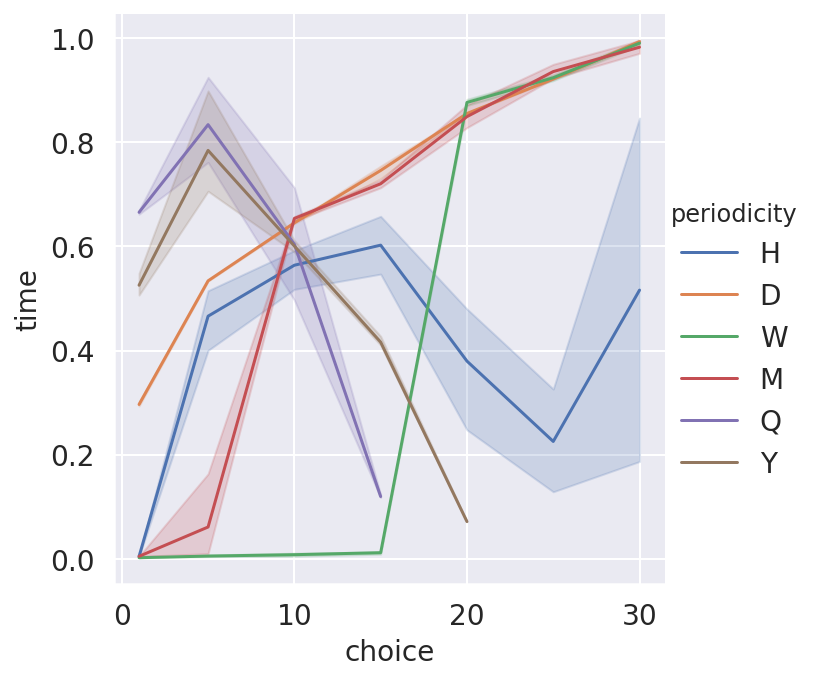

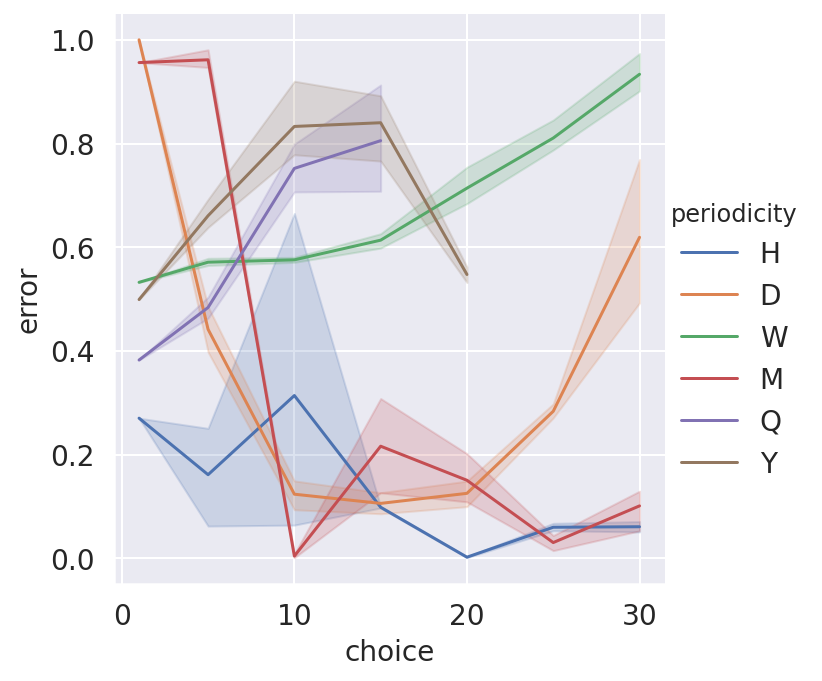

In [85]:
normalized_df_times = []
normalized_df_errors = []
for periodicity in df_times['periodicity'].unique():
    cur_time = df_times[df_times['periodicity'] == periodicity]['time']
    normalized_df_times.append(cur_time / cur_time.max())
    cur_error = df_errors[df_errors['periodicity'] == periodicity]['error']
    normalized_df_errors.append(cur_error / cur_error.max())
normalized_df_times = pd.concat(normalized_df_times)
normalized_df_times = pd.DataFrame({'time': normalized_df_times, 'periodicity': df_times['periodicity'], 'choice': df_times['choice']})
normalized_df_errors = pd.concat(normalized_df_errors)
normalized_df_errors = pd.DataFrame({'error': normalized_df_errors, 'periodicity': df_errors['periodicity'], 'choice': df_errors['choice']})
plot = sns.relplot(x='choice', y='time', hue='periodicity', data=normalized_df_times, kind='line')
fig = plot.figure
fig.savefig(fname='hyper-ar_depth-time.pdf', format='svg')
plt.show()
plot = sns.relplot(x='choice', y='error', hue='periodicity', data=normalized_df_errors, kind='line')
fig = plot.figure
fig.savefig(fname='hyper-ar_depth-mse.pdf', format='svg')
plt.show()

Мы видим, что при параметре `ar_depth=1` мы получаем лучшие значения MSE на тестирующей выборке для половины рядов. Для остальных лучшее значение от 10 до 20. Поэтому предлагаю взять за дефолт `ar_depth=1`.

### `seas_depth`

В данном эксперименте будет тестироваться сезонная динамическая регрессия. Ряд Y1 не будет рассмотрен. Параметры `sp` для разных сезонностей рядов:
- H: 24
- D: 30
- W: 4
- Q: 4
- M: 12

Параметр `seas_depth` будет подбираться среди значений [1, 2, 3, 4].

In [92]:
fh = np.array([5])
choices = [1, 2, 3, 4]
sps = {
    'H': 24,
    'D': 30,
    'W': 4,
    'Q': 4,
    'M': 12
}
df_times = pd.DataFrame(columns=['time', 'periodicity', 'choice'])
df_errors = pd.DataFrame(columns=['error', 'periodicity', 'choice'])
experiments = 5
row_iter = 0
for series in tqdm(columns):
    if series.startswith('Y'):
        continue
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    for seas_depth in choices:
        for exp in range(experiments):
            if sps[series[0]] * seas_depth + 5 > train.shape[0]:
                continue
            model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=1, sp=sps[series[0]], seas_depth=seas_depth)
            status, history = model.fit(train, trace=True)
            if status == 'iterations_exceeded':
                print(f"Series {series} did not converge with seas_depth {seas_depth}")
                print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            df_times.loc[row_iter] = (history['time'][-1], series[0], seas_depth)
            df_errors.loc[row_iter] = (mean_squared_error([test[fh - 1]], model.predict(train)), series[0], seas_depth)
            row_iter += 1

  0%|          | 0/6 [00:00<?, ?it/s]

Series H1 did not converge with seas_depth 1
Tolerance is 0.007943749509870111
Series H1 did not converge with seas_depth 1
Tolerance is 0.024275851861891514
Series H1 did not converge with seas_depth 1
Tolerance is 0.004038304878398919
Series H1 did not converge with seas_depth 2
Tolerance is 0.007436549367067797
Series H1 did not converge with seas_depth 2
Tolerance is 0.007159851780574854
Series H1 did not converge with seas_depth 2
Tolerance is 0.004903741182573068
Series H1 did not converge with seas_depth 3
Tolerance is 0.008809663128338148
Series H1 did not converge with seas_depth 3
Tolerance is 0.0058610946596152624
Series H1 did not converge with seas_depth 3
Tolerance is 0.003578434736903706
Series H1 did not converge with seas_depth 3
Tolerance is 0.006220766321478319
Series H1 did not converge with seas_depth 4
Tolerance is 0.0030799468425769757
Series H1 did not converge with seas_depth 4
Tolerance is 0.005457045738368877
Series H1 did not converge with seas_depth 4
Toler

In [91]:
df_times

,time,periodicity,choice
0,32.157639,H,30
1,3.317553,H,30
2,3.620705,H,30
3,8.210161,H,30
4,0.994032,H,30
...,...,...,...
90,0.006628,Q,30
91,0.004435,Q,30
92,0.004354,Q,30
93,0.004586,Q,30


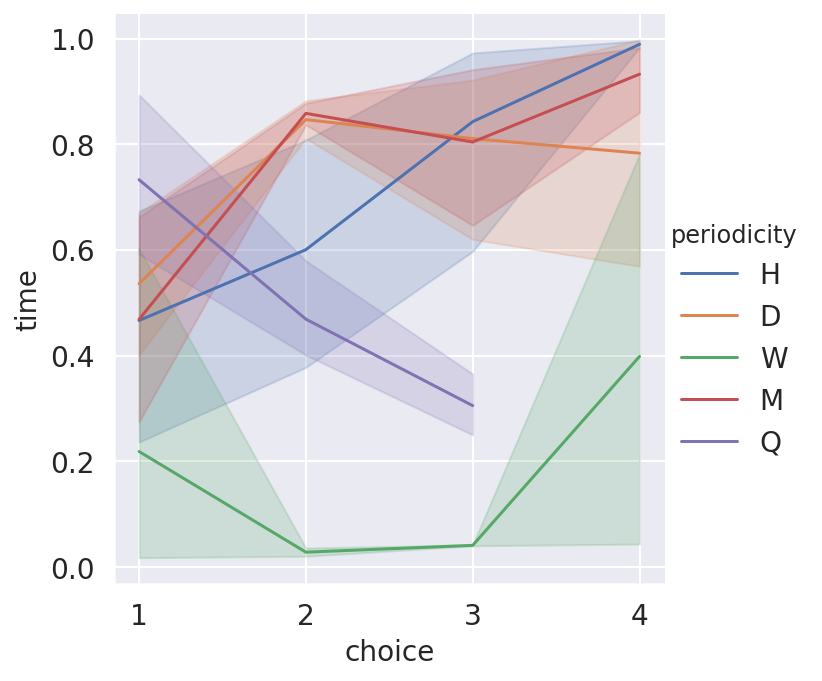

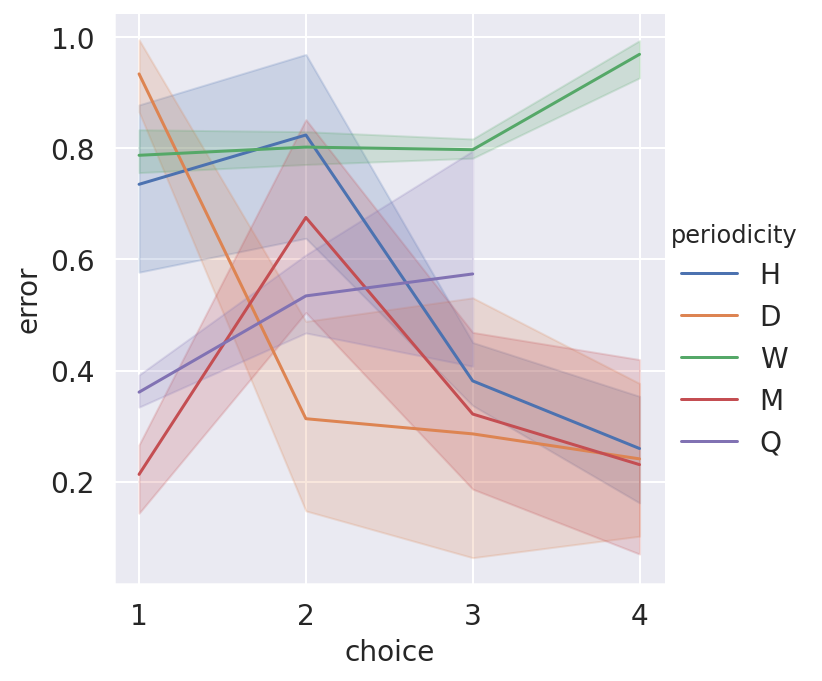

In [93]:
normalized_df_times = []
normalized_df_errors = []
for periodicity in df_times['periodicity'].unique():
    cur_time = df_times[df_times['periodicity'] == periodicity]['time']
    normalized_df_times.append(cur_time / cur_time.max())
    cur_error = df_errors[df_errors['periodicity'] == periodicity]['error']
    normalized_df_errors.append(cur_error / cur_error.max())
normalized_df_times = pd.concat(normalized_df_times)
normalized_df_times = pd.DataFrame({'time': normalized_df_times, 'periodicity': df_times['periodicity'], 'choice': df_times['choice']})
normalized_df_errors = pd.concat(normalized_df_errors)
normalized_df_errors = pd.DataFrame({'error': normalized_df_errors, 'periodicity': df_errors['periodicity'], 'choice': df_errors['choice']})
plot = sns.relplot(x='choice', y='time', hue='periodicity', data=normalized_df_times, kind='line')
fig = plot.figure
fig.savefig(fname='hyper-seas_depth-time.pdf', format='pdf')
plt.show()
plot = sns.relplot(x='choice', y='error', hue='periodicity', data=normalized_df_errors, kind='line')
fig = plot.figure
fig.savefig(fname='hyper-seas_depth-mse.pdf', format='pdf')
plt.show()

Для трёх рядов оптимальным `seas_depth` оказался 1, для двух -- 4. Таким образом, `seas_depth=1` оказывается лучшим вариантом.

### `fit_intercept`

Параметр `fit_intercept` будет подбираться среди значений [True, False]. Слева значение False, справа значение True.

In [94]:
fh = np.array([5])
choices = [False, True]
df_times = pd.DataFrame(columns=['time', 'periodicity', 'choice'])
df_errors = pd.DataFrame(columns=['error', 'periodicity', 'choice'])
experiments = 5
row_iter = 0
for series in tqdm(columns):
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    for fit_intercept in choices:
        for exp in range(experiments):
            model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=1, fit_intercept=fit_intercept)
            status, history = model.fit(train, trace=True)
            if status == 'iterations_exceeded':
                print(f"Series {series} did not converge with fit_intercept {fit_intercept}")
                print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            df_times.loc[row_iter] = (history['time'][-1], series[0], fit_intercept)
            df_errors.loc[row_iter] = (mean_squared_error([test[fh - 1]], model.predict(train)), series[0], fit_intercept)
            row_iter += 1

  0%|          | 0/6 [00:00<?, ?it/s]

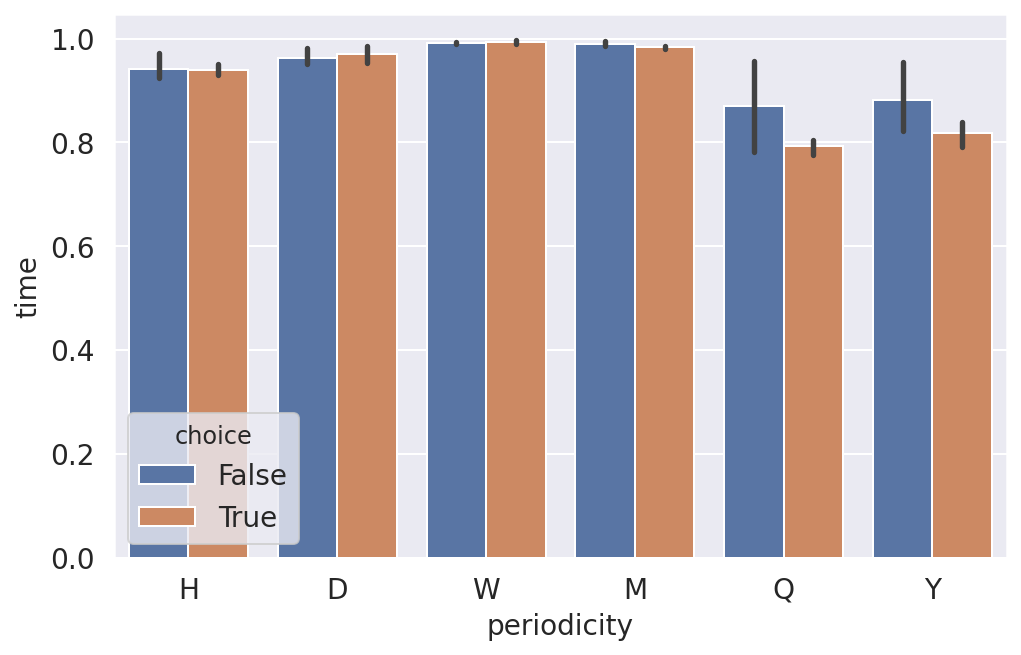

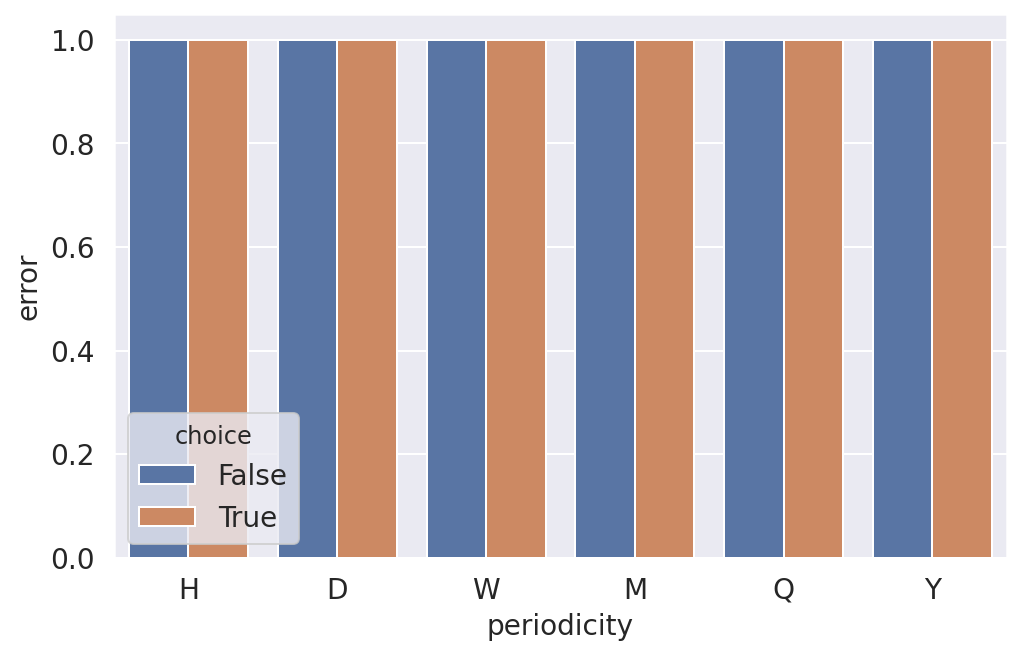

In [95]:
df_times['choice'] = df_times['choice'].astype(str)
df_errors['choice'] = df_errors['choice'].astype(str)
normalized_df_times = []
normalized_df_errors = []
for periodicity in df_times['periodicity'].unique():
    cur_time = df_times[df_times['periodicity'] == periodicity]['time']
    normalized_df_times.append(cur_time / cur_time.max())
    cur_error = df_errors[df_errors['periodicity'] == periodicity]['error']
    normalized_df_errors.append(cur_error / cur_error.max())
normalized_df_times = pd.concat(normalized_df_times)
normalized_df_times = pd.DataFrame({'time': normalized_df_times, 'periodicity': df_times['periodicity'], 'choice': df_times['choice']})
normalized_df_errors = pd.concat(normalized_df_errors)
normalized_df_errors = pd.DataFrame({'error': normalized_df_errors, 'periodicity': df_errors['periodicity'], 'choice': df_errors['choice']})
plot = sns.barplot(x='periodicity', y='time', hue='choice', data=normalized_df_times)
fig = plot.get_figure()
fig.savefig(fname='hyper-fit_intercept-time.svg', format='svg')
plt.show()
plot = sns.barplot(x='periodicity', y='error', hue='choice', data=normalized_df_errors)
fig = plot.get_figure()
fig.savefig(fname='hyper-fit_intercept-mse.svg', format='svg')
plt.show()

В этом случае по MSE более-менее одинаковые варианты, но по времени немного выигрывает вариант с fit_intercept=True. Поэтому будем фиттить.

### `tolerance`

Параметр `tolerance` будет подбираться по логарифмической сетке между значениями [1, 1e-8].

In [97]:
fh = np.array([5])
choices = np.logspace(-8, 0, 9)[::-1]
convergence_failures = {key: 0 for key in choices}
df_times = pd.DataFrame(columns=['time', 'periodicity', 'choice'])
df_errors = pd.DataFrame(columns=['error', 'periodicity', 'choice'])
experiments = 5
row_iter = 0
for series in tqdm(columns):
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    for tolerance in choices:
        for exp in range(experiments):
            model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=1, tolerance=tolerance, max_iter=1000)
            status, history = model.fit(train, trace=True)
            if status == 'iterations_exceeded':
                print(f"Series {series} did not converge with tolerance {tolerance}")
                print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
                convergence_failures[tolerance] += 1
            df_times.loc[row_iter] = (history['time'][-1], series[0], tolerance)
            df_errors.loc[row_iter] = (mean_squared_error([test[fh - 1]], model.predict(train)), series[0], tolerance)
            row_iter += 1
print(convergence_failures)

  0%|          | 0/6 [00:00<?, ?it/s]

Series H1 did not converge with tolerance 1e-06
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-06
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-06
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-06
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-06
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-07
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-07
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-07
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-07
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-07
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-08
Tolerance is 1.3141522241173761e-05
Series H1 did not converge with tolerance 1e-08
Tolerance is 1.3141522241173

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


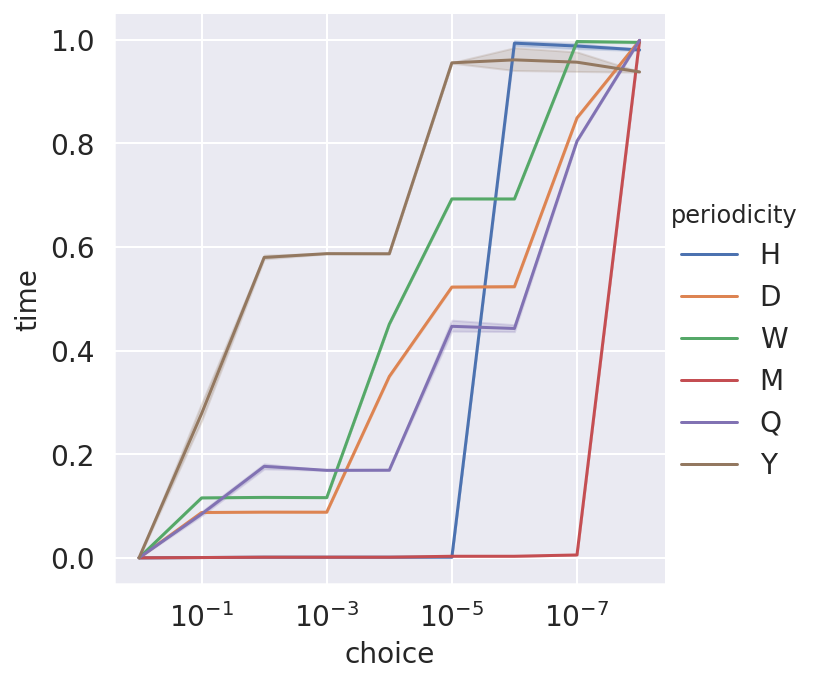

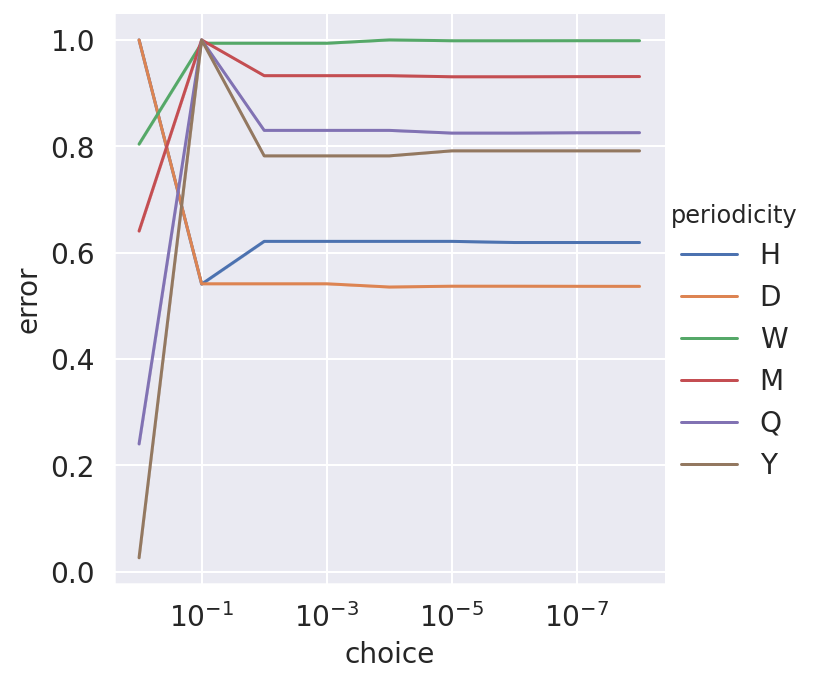

In [101]:
normalized_df_times = []
normalized_df_errors = []
for periodicity in df_times['periodicity'].unique():
    cur_time = df_times[df_times['periodicity'] == periodicity]['time']
    normalized_df_times.append(cur_time / cur_time.max())
    cur_error = df_errors[df_errors['periodicity'] == periodicity]['error']
    normalized_df_errors.append(cur_error / cur_error.max())
normalized_df_times = pd.concat(normalized_df_times)
normalized_df_times = pd.DataFrame({'time': normalized_df_times, 'periodicity': df_times['periodicity'], 'choice': df_times['choice']})
normalized_df_errors = pd.concat(normalized_df_errors)
normalized_df_errors = pd.DataFrame({'error': normalized_df_errors, 'periodicity': df_errors['periodicity'], 'choice': df_errors['choice']})
plot = sns.relplot(x='choice', y='time', hue='periodicity', data=normalized_df_times, kind='line')
plot.axes[0][0].invert_xaxis()
plot.axes[0][0].set_xscale('log')
fig = plot.figure
fig.savefig(fname='hyper-tolerance-time.svg', format='svg')
plt.show()
plot = sns.relplot(x='choice', y='error', hue='periodicity', data=normalized_df_errors, kind='line')
plot.axes[0][0].invert_xaxis()
plot.axes[0][0].set_xscale('log')
fig = plot.figure
fig.savefig(fname='hyper-tolerance-mse.svg', format='svg')
plt.show()

Вообще говоря, судя по всему, очень быстро переобучается модель, но взять `tolerance=1` означало бы не использовать динамическую регрессию. Среди остальных при tolerance=0.01 мы видим улучшение на половине рядов, боковой тренд на двух и ухудшение на одном. Поэтому я думаю, что правильно взять `tolerance=0.01`.

### `max_iter`

Это единственный необычный эксперимент. Цель `max_iter` -- быть достаточно большим, чтобы удовлетворять сходимости до нужного `tolerance` и не быть больше, поэтому здесь я буду считать только долю сошедшихся запусков градиентного спуска по логарифмической сетке среди значений [10, 1000000]. Выберу минимальный, на котором все или почти все ряды сойдутся.

In [105]:
fh = np.array([5])
choices = np.logspace(0, 6, 7).astype(int)
convergence_failures = {key: 0 for key in choices}
experiments = 5
for series in tqdm(columns):
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    for max_iter in choices:
        for exp in range(experiments):
            model = DynamicRegression(fh=[5], tolerance=1e-2, learning_steps=np.array([5]), ar_depth=1, max_iter=max_iter)
            status, history = model.fit(train, trace=True)
            if status == 'iterations_exceeded':
                print(f"Series {series} did not converge with max_iter {max_iter}")
                print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
                convergence_failures[max_iter] += 1
print(convergence_failures)

  0%|          | 0/6 [00:00<?, ?it/s]

Series H1 did not converge with max_iter 1
Tolerance is 0.05769624185598849
Series H1 did not converge with max_iter 1
Tolerance is 0.05769624185598849
Series H1 did not converge with max_iter 1
Tolerance is 0.05769624185598849
Series H1 did not converge with max_iter 1
Tolerance is 0.05769624185598849
Series H1 did not converge with max_iter 1
Tolerance is 0.05769624185598849
Series M1 did not converge with max_iter 1
Tolerance is 0.04300571762937249
Series M1 did not converge with max_iter 1
Tolerance is 0.04300571762937249
Series M1 did not converge with max_iter 1
Tolerance is 0.04300571762937249
Series M1 did not converge with max_iter 1
Tolerance is 0.04300571762937249
Series M1 did not converge with max_iter 1
Tolerance is 0.04300571762937249
Series Q1 did not converge with max_iter 1
Tolerance is 0.044933402240590295
Series Q1 did not converge with max_iter 1
Tolerance is 0.044933402240590295
Series Q1 did not converge with max_iter 1
Tolerance is 0.044933402240590295
Series Q1

При `max_iter=10` уже всё сходится к нужной `tolerance`, так что возьмём его по умолчанию.

### Стартовый набор параметров

Я вижу три разумных метода выбора набора параметров:
- Случайный, отнормированный так, чтобы сумма была равна 1.
- Равный частным автокорреляциям с лагами.
- Равный частным автокорреляциям с лагами, отнормированный так, чтобы сумма была равна 1.


In [107]:
fh = np.array([5])
choices = ['random', 'pacf_norm', 'pacf']
df_times = pd.DataFrame(columns=['time', 'periodicity', 'choice'])
df_errors = pd.DataFrame(columns=['error', 'periodicity', 'choice'])
experiments = 5
row_iter = 0
for series in tqdm(columns):
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    for starting_params in choices:
        for exp in range(experiments):
            model = DynamicRegression(fh=[5], tolerance=1e-2, learning_steps=np.array([5]), ar_depth=1, max_iter=10)
            status, history = model.fit(train, trace=True, starting_params=starting_params)
            if status == 'iterations_exceeded':
                print(f"Series {series} did not converge with starting_params {starting_params}")
                print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            df_times.loc[row_iter] = (history['time'][-1], series[0], starting_params)
            df_errors.loc[row_iter] = (mean_squared_error([test[fh - 1]], model.predict(train)), series[0], starting_params)
            row_iter += 1

  0%|          | 0/6 [00:00<?, ?it/s]

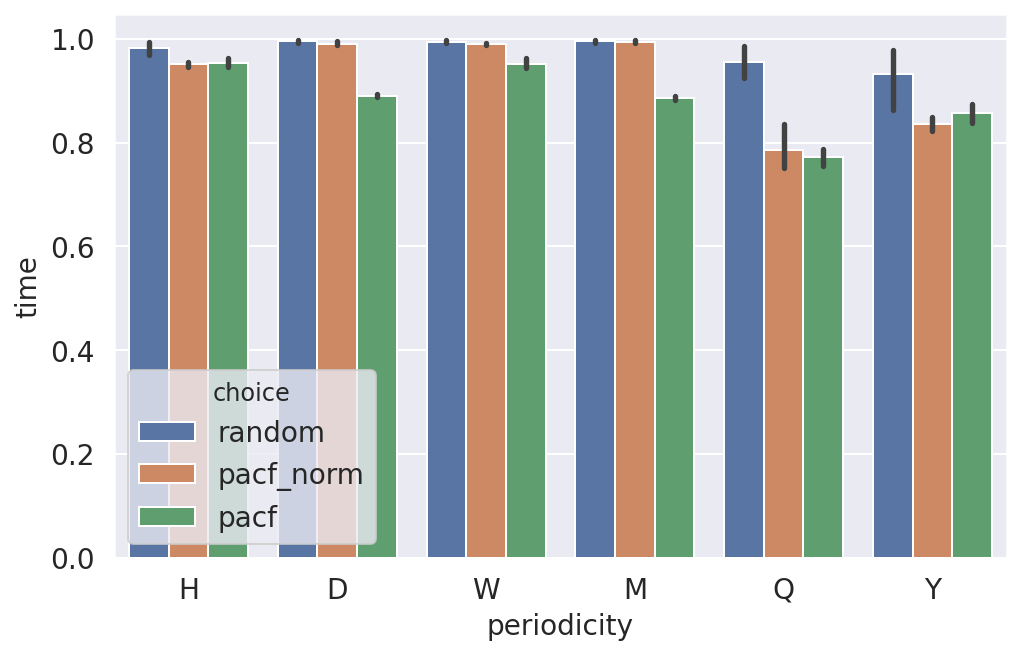

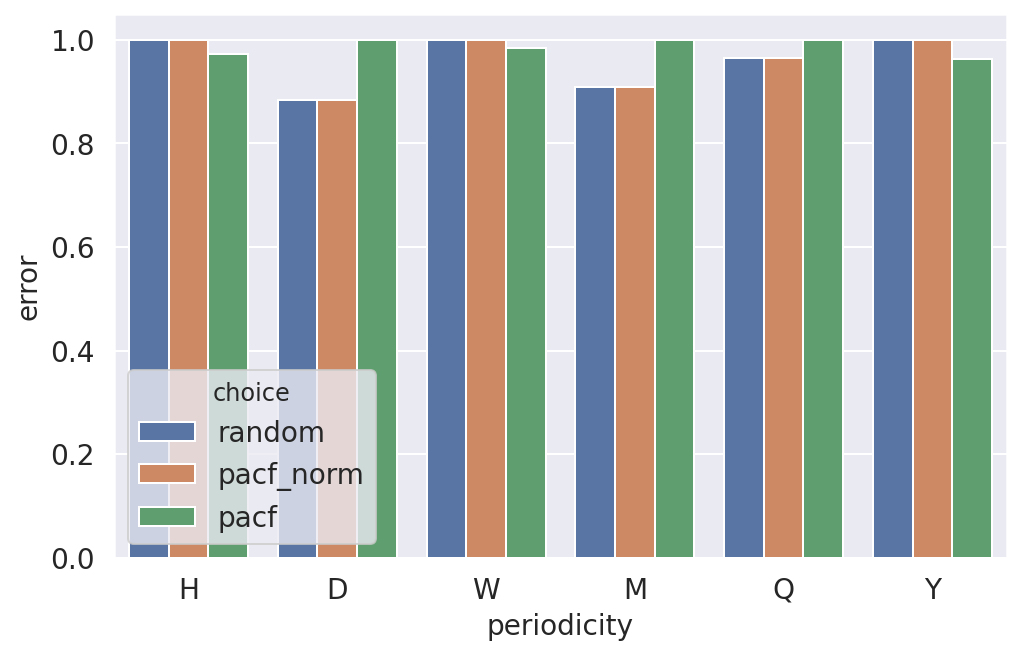

In [108]:
normalized_df_times = []
normalized_df_errors = []
for periodicity in df_times['periodicity'].unique():
    cur_time = df_times[df_times['periodicity'] == periodicity]['time']
    normalized_df_times.append(cur_time / cur_time.max())
    cur_error = df_errors[df_errors['periodicity'] == periodicity]['error']
    normalized_df_errors.append(cur_error / cur_error.max())
normalized_df_times = pd.concat(normalized_df_times)
normalized_df_times = pd.DataFrame({'time': normalized_df_times, 'periodicity': df_times['periodicity'], 'choice': df_times['choice']})
normalized_df_errors = pd.concat(normalized_df_errors)
normalized_df_errors = pd.DataFrame({'error': normalized_df_errors, 'periodicity': df_errors['periodicity'], 'choice': df_errors['choice']})
plot = sns.barplot(x='periodicity', y='time', hue='choice', data=normalized_df_times)
fig = plot.get_figure()
fig.savefig(fname='hyper-starting_params-time.svg', format='svg')
plt.show()
plot = sns.barplot(x='periodicity', y='error', hue='choice', data=normalized_df_errors)
fig = plot.get_figure()
fig.savefig(fname='hyper-starting_params-mse.svg', format='svg')
plt.show()

При `ar_depth=1` понятно, что параметры `random` и `pacf_norm` совпадают и равны 1 (оба они лучше чем `pacf` по MSE на тестирующей выборке). Поэтому давайте попробуем с `ar_depth=15`:

In [111]:
fh = np.array([5])
choices = ['random', 'pacf_norm', 'pacf']
df_times = pd.DataFrame(columns=['time', 'periodicity', 'choice'])
df_errors = pd.DataFrame(columns=['error', 'periodicity', 'choice'])
experiments = 5
row_iter = 0
for series in tqdm(columns):
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    for starting_params in choices:
        for exp in range(experiments):
            if ar_depth + 5 > train.shape[0]:
                continue
            model = DynamicRegression(fh=[5], tolerance=1e-2, learning_steps=np.array([5]), ar_depth=15, max_iter=10)
            status, history = model.fit(train, trace=True, starting_params=starting_params)
            if status == 'iterations_exceeded':
                print(f"Series {series} did not converge with starting_params {starting_params}")
                print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            df_times.loc[row_iter] = (history['time'][-1], series[0], starting_params)
            df_errors.loc[row_iter] = (mean_squared_error([test[fh - 1]], model.predict(train)), series[0], starting_params)
            row_iter += 1

  0%|          | 0/6 [00:00<?, ?it/s]

Series H1 did not converge with starting_params random
Tolerance is 0.19995787280050212
Series H1 did not converge with starting_params random
Tolerance is 0.195955459058179
Series H1 did not converge with starting_params random
Tolerance is 0.13929271568518486
Series H1 did not converge with starting_params random
Tolerance is 0.14716194096012855
Series H1 did not converge with starting_params random
Tolerance is 0.13694592995726354
Series H1 did not converge with starting_params pacf
Tolerance is 0.05374847468487845
Series H1 did not converge with starting_params pacf
Tolerance is 0.05374847468487845
Series H1 did not converge with starting_params pacf
Tolerance is 0.05374847468487845
Series H1 did not converge with starting_params pacf
Tolerance is 0.05374847468487845
Series H1 did not converge with starting_params pacf
Tolerance is 0.05374847468487845
Series W1 did not converge with starting_params pacf_norm
Tolerance is 0.45011519079613665
Series W1 did not converge with starting_

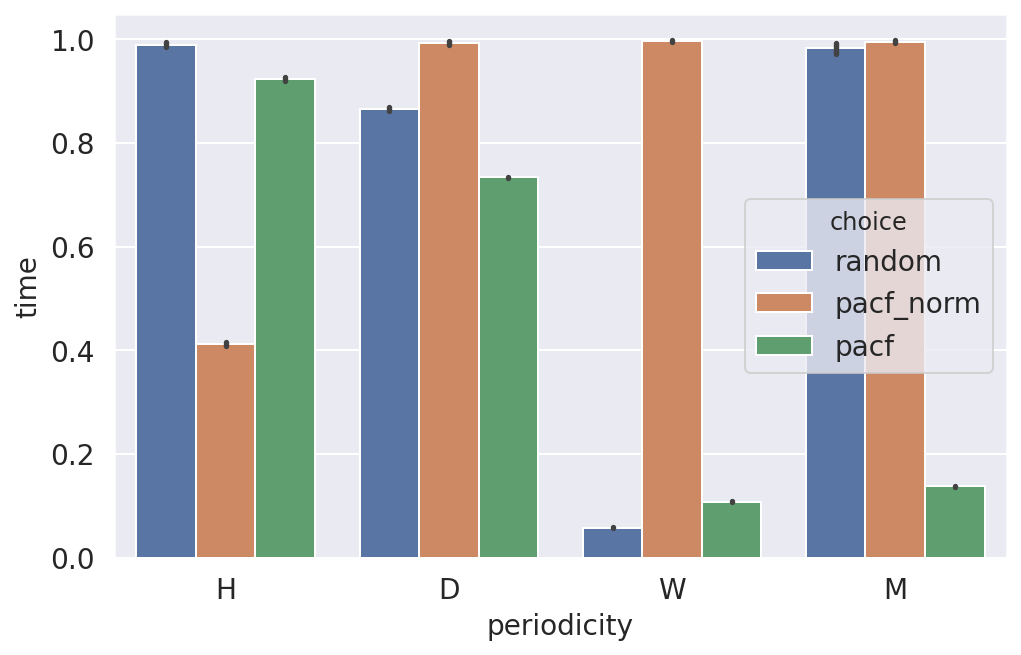

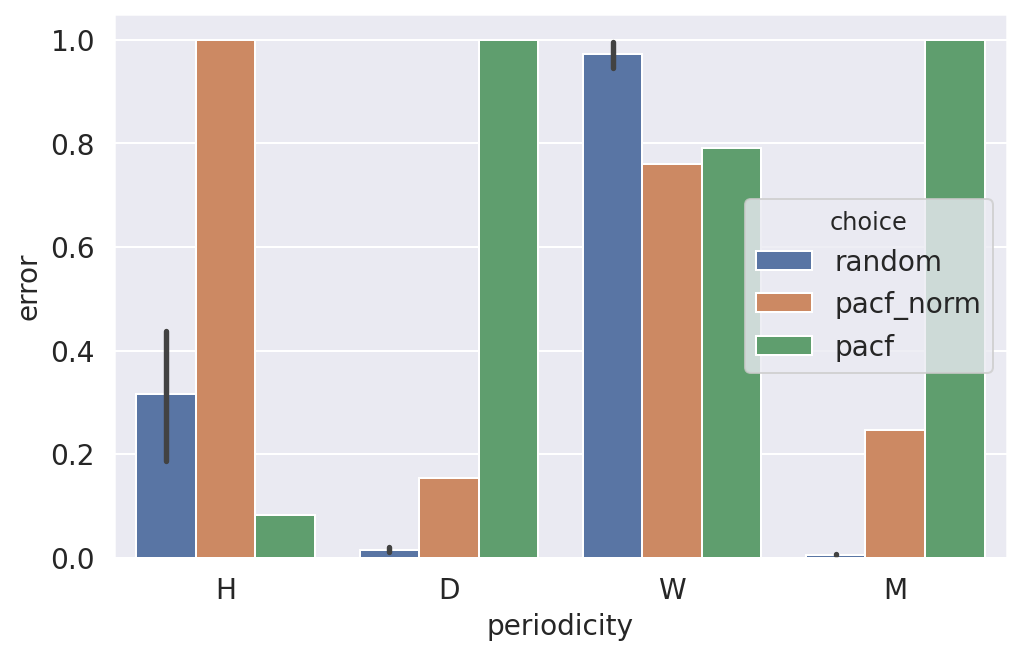

In [112]:
normalized_df_times = []
normalized_df_errors = []
for periodicity in df_times['periodicity'].unique():
    cur_time = df_times[df_times['periodicity'] == periodicity]['time']
    normalized_df_times.append(cur_time / cur_time.max())
    cur_error = df_errors[df_errors['periodicity'] == periodicity]['error']
    normalized_df_errors.append(cur_error / cur_error.max())
normalized_df_times = pd.concat(normalized_df_times)
normalized_df_times = pd.DataFrame({'time': normalized_df_times, 'periodicity': df_times['periodicity'], 'choice': df_times['choice']})
normalized_df_errors = pd.concat(normalized_df_errors)
normalized_df_errors = pd.DataFrame({'error': normalized_df_errors, 'periodicity': df_errors['periodicity'], 'choice': df_errors['choice']})
plot = sns.barplot(x='periodicity', y='time', hue='choice', data=normalized_df_times)
fig = plot.get_figure()
fig.savefig(fname='hyper-starting_params_normalized-time.svg', format='svg')
plt.show()
plot = sns.barplot(x='periodicity', y='error', hue='choice', data=normalized_df_errors)
fig = plot.get_figure()
fig.savefig(fname='hyper-starting_params_normalized-mse.svg', format='svg')
plt.show()

По MSE лучшим параметром всё-таки кажется `random`. При этом видно, что пара рядов не сошлась, но главное что MSE хороший. Так что возьмём его.

### `lr_finder`

Здесь есть четыре способа:
- Constant с $\alpha = 10^{-3}$;
- Formula, `starting_alpha=5e-3`;
- Armijo, стартовый $\alpha = 1$;
- Wolfe, стартовый $\alpha = 1$.

In [114]:
fh = np.array([5])
choices = ['Constant', 'Formula', 'Armijo', 'Wolfe']
df_times = pd.DataFrame(columns=['time', 'periodicity', 'choice'])
experiments = 5
row_iter = 0
for series in tqdm(columns):
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    for lr_finder in choices:
        for exp in range(experiments):
            model = DynamicRegression(fh=[5], tolerance=1e-2, learning_steps=np.array([5]), ar_depth=1, max_iter=10)
            status, history = model.fit(train, trace=True, lr_finder=lr_finder)
            if status == 'iterations_exceeded':
                print(f"Series {series} did not converge with lr_finder {lr_finder}")
                print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            df_times.loc[row_iter] = (history['time'][-1], series[0], lr_finder)
            df_errors.loc[row_iter] = (mean_squared_error([test[fh - 1]], model.predict(train)), series[0], lr_finder)
            row_iter += 1

  0%|          | 0/6 [00:00<?, ?it/s]

Series D1 did not converge with lr_finder Constant
Tolerance is 1.0000000000143545
Series D1 did not converge with lr_finder Constant
Tolerance is 1.0000000000143545
Series D1 did not converge with lr_finder Constant
Tolerance is 1.0000000000143545
Series D1 did not converge with lr_finder Constant
Tolerance is 1.0000000000143545
Series D1 did not converge with lr_finder Constant
Tolerance is 1.0000000000143545
Series W1 did not converge with lr_finder Constant
Tolerance is 0.05153890454970631
Series W1 did not converge with lr_finder Constant
Tolerance is 0.05153890454970631
Series W1 did not converge with lr_finder Constant
Tolerance is 0.05153890454970631
Series W1 did not converge with lr_finder Constant
Tolerance is 0.05153890454970631
Series W1 did not converge with lr_finder Constant
Tolerance is 0.05153890454970631
Series W1 did not converge with lr_finder Formula
Tolerance is 0.059267547305932006
Series W1 did not converge with lr_finder Formula
Tolerance is 0.0592675473059320

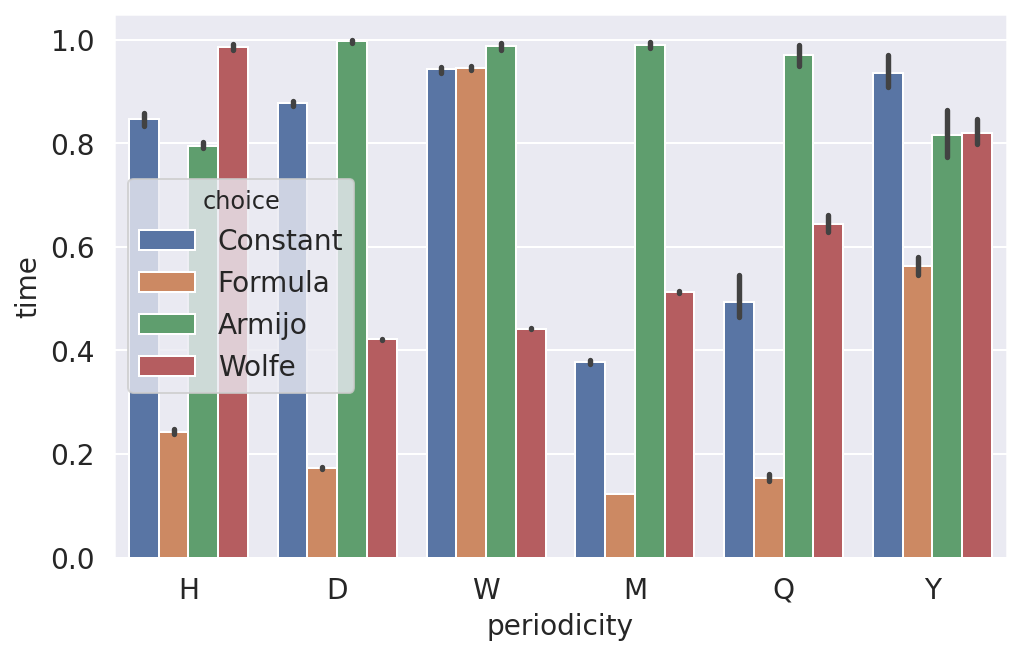

In [115]:
normalized_df_times = []
for periodicity in df_times['periodicity'].unique():
    cur_time = df_times[df_times['periodicity'] == periodicity]['time']
    normalized_df_times.append(cur_time / cur_time.max())
normalized_df_times = pd.concat(normalized_df_times)
normalized_df_times = pd.DataFrame({'time': normalized_df_times, 'periodicity': df_times['periodicity'], 'choice': df_times['choice']})
plot = sns.barplot(x='periodicity', y='time', hue='choice', data=normalized_df_times)
fig = plot.get_figure()
fig.savefig(fname='hyper-lr_finder-time.svg', format='svg')
plt.show()

В пяти из шести случаев лучший вариант -- Formula, с `starting_alpha=5e-3`. Однозначно стоит брать этот вариант.